## Analysis
Do the following analyses:
1. Plot mean rewards together for all runs by task
2. Plot success rate together for all runs by task
3. Plot Quantile of rewards together for all runs by task
4. Evaluate gating values and performance

Need a way of splitting out algorithm, task, run

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from plotting_utils import *

In [2]:
EXPERIMENT_LOG = '../../experiment_log.csv'
experiment_log = pd.read_csv(EXPERIMENT_LOG)


In [3]:
push_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='push-v2', setting='random')
reach_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='reach-v2', setting='random')
pick_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='pick-place-v2', setting='random')
faucet_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='faucet-open-v2', setting='random')
door_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='door-open-v2', setting='random')
button_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='button-press-v2', setting='random')

In [4]:
## create baseline plot for right

In [4]:
all_experiments = [
    push_experiments,
    reach_experiments,
    pick_experiments,
    faucet_experiments,
    door_experiments,
    button_experiments
]
test_data = pd.concat([experiment.get_result_group_data('test_results') for experiment in all_experiments])
train_data = pd.concat([experiment.get_result_group_data('train_results') for experiment in all_experiments])
left_eval_data = pd.concat([experiment.get_result_group_data('left_eval_results') for experiment in all_experiments])
# train_data = pd.concat(faucet_experiments.get_result_group_data('train_results')
# left_eval_data = faucet_experiments.get_result_group_data('left_eval_results')


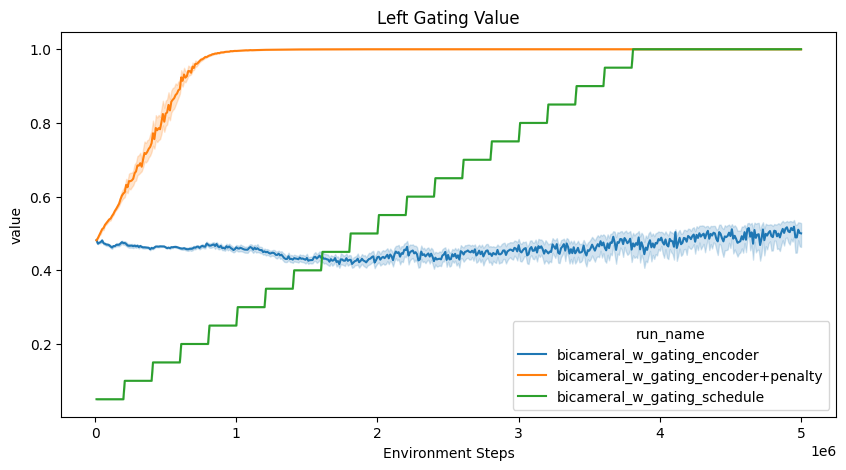

In [5]:
plot_gating_values(
    train_data.query("run_name.str.contains('bicameral')"), 
    title = "Left Gating Value", 
    figsize = (10, 5))

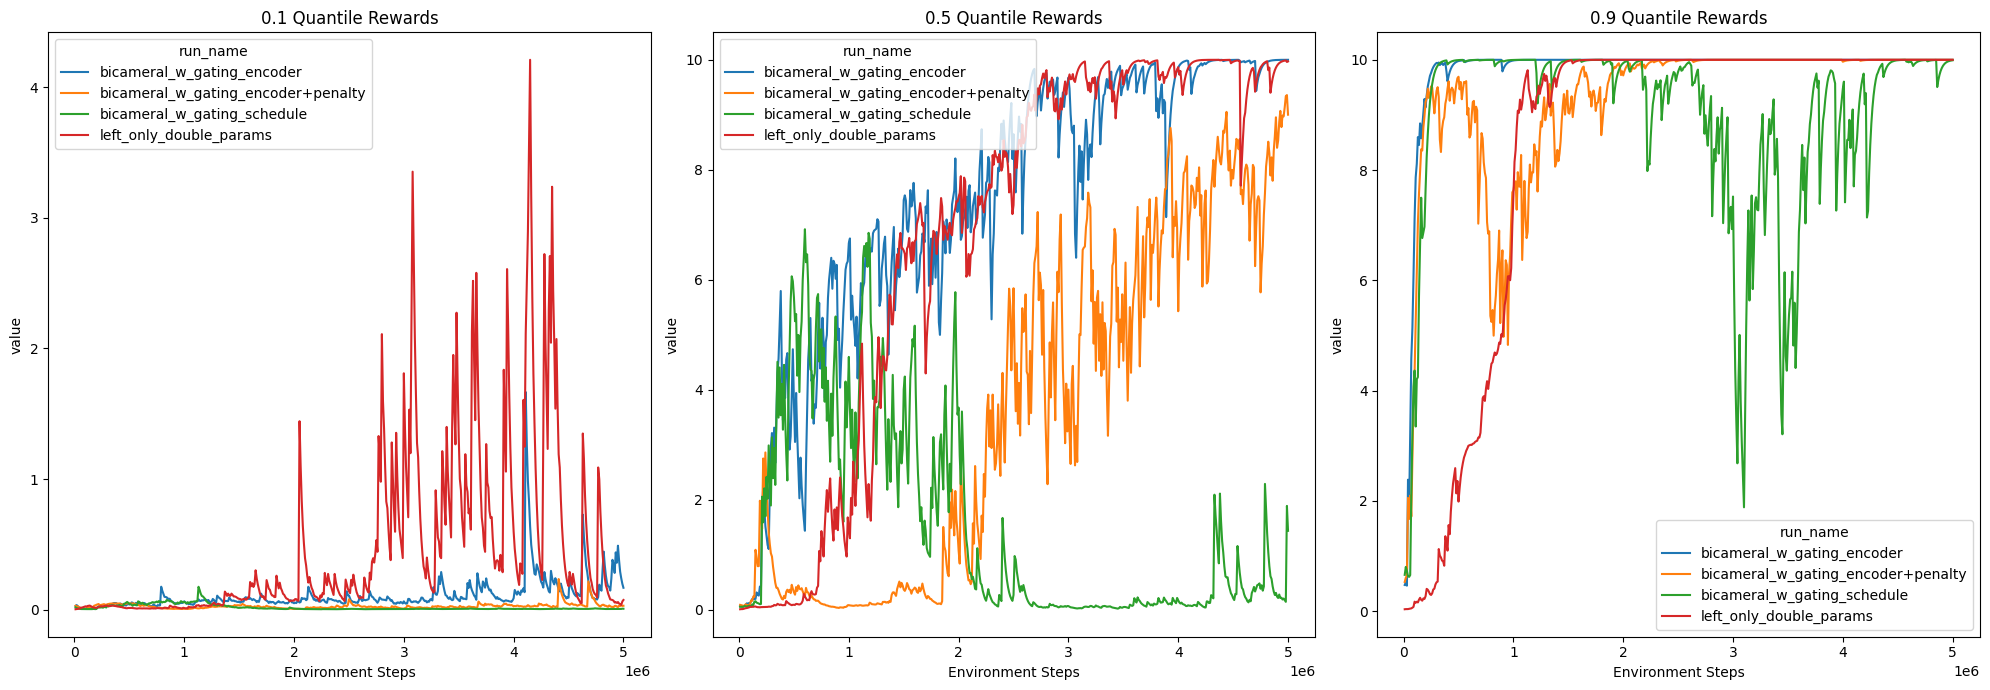

In [6]:
plot_rew_quantiles(
    (
        train_data
        .query(
            'run_name.isin(["bicameral_w_gating_encoder", "bicameral_w_gating_schedule","bicameral_w_gating_encoder+penalty", "left_only_double_params"])'
            )
    ), 
    alpha = .25)

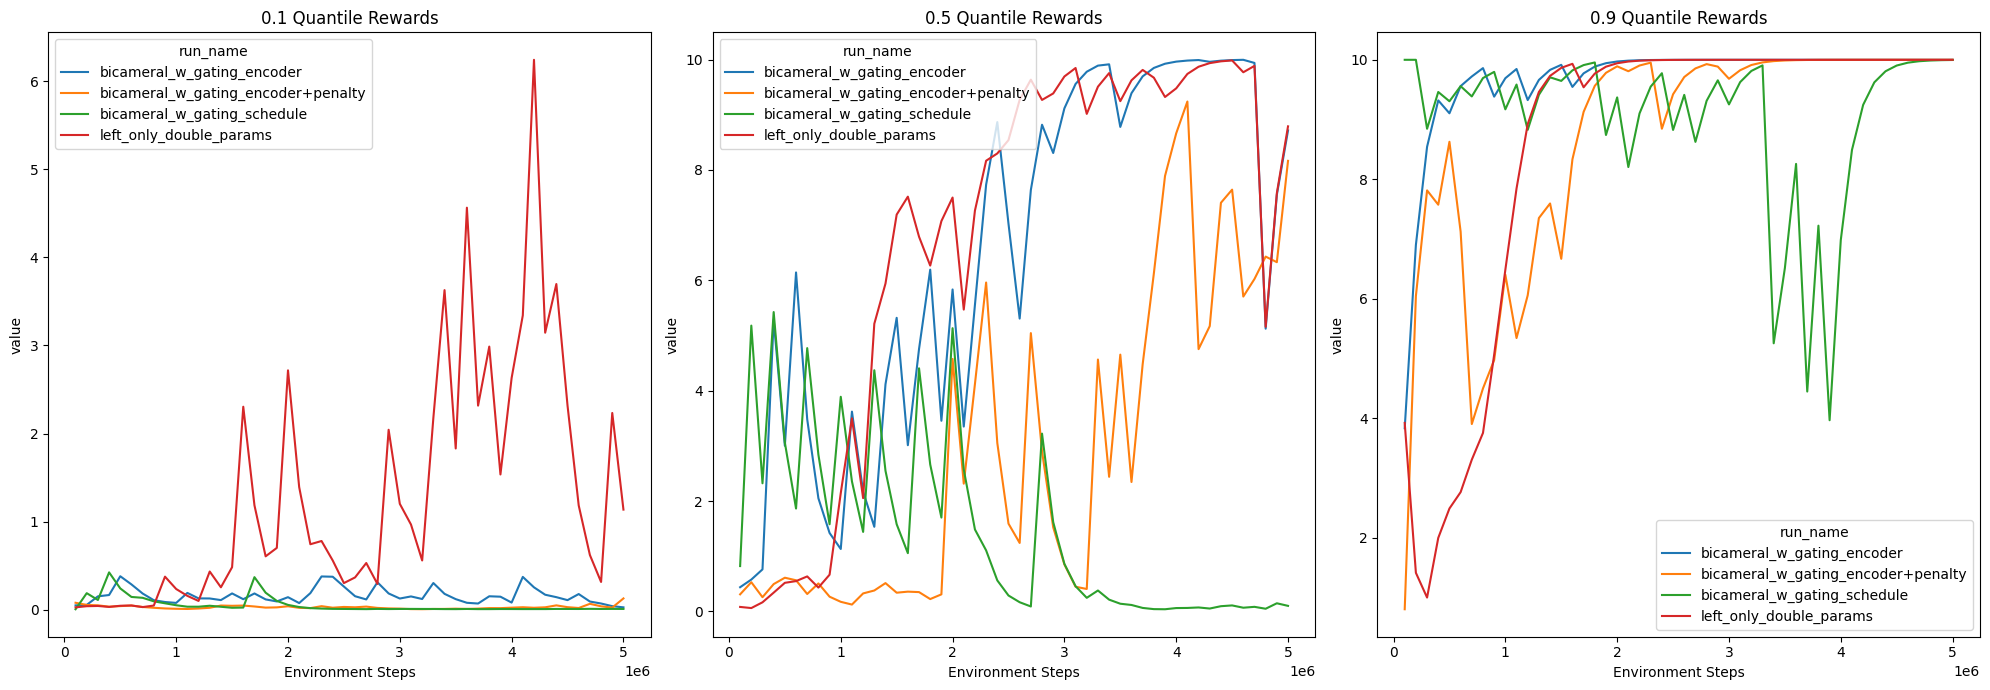

In [7]:
plot_rew_quantiles(
    test_data.query('run_name.isin(["bicameral_w_gating_encoder", "bicameral_w_gating_schedule","bicameral_w_gating_encoder+penalty", "left_only_double_params"])'), 
    alpha = .5)

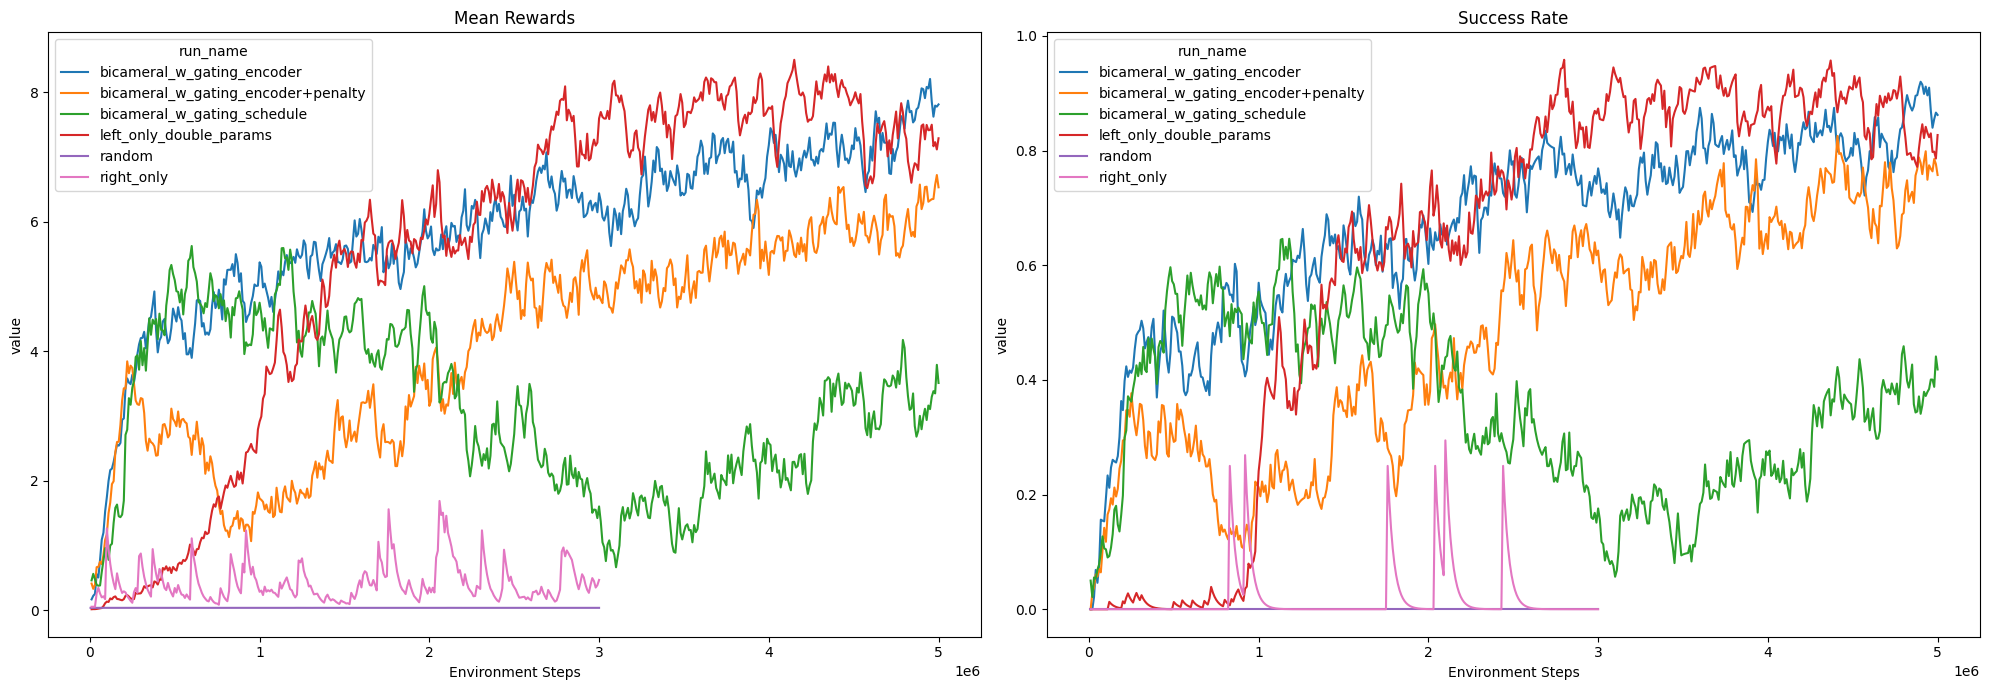

In [8]:
plot_rew_and_succ(train_data, alpha = .25)

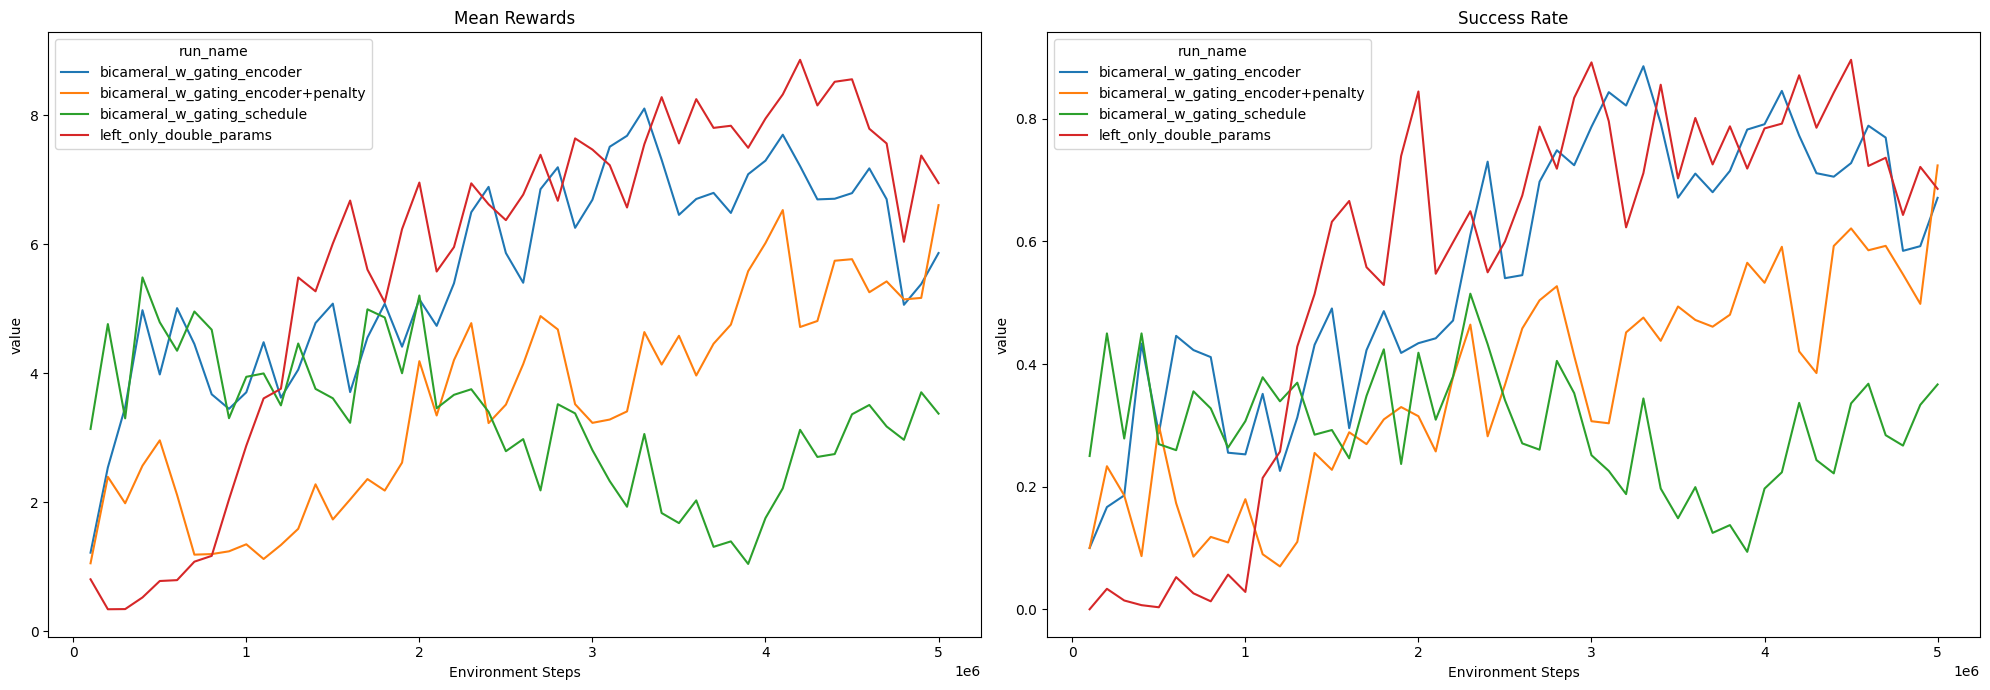

In [9]:
plot_rew_and_succ(test_data, alpha = .5)

In [63]:
not_to_plot = ['random', 'right_only']
col_to_do = 'num_successes'

tmp_df = (
    train_data
    .loc[:, ['run_name', col_to_do, 'frame']]
    .query(f'~run_name.isin({not_to_plot})')
)

tmp_df['cumulative_reward']=(
    tmp_df
    .loc[:, ['run_name', col_to_do]]
    .groupby('run_name')
    [col_to_do].cumsum()
)

tmp_df

,run_name,num_successes,frame,cumulative_reward
0,left_only_double_params,0.00,10000,0.00
1,left_only_double_params,0.00,20000,0.00
2,left_only_double_params,0.15,30000,0.15
3,left_only_double_params,0.15,40000,0.30
4,left_only_double_params,0.25,50000,0.55
...,...,...,...,...
495,bicameral_w_gating_encoder+penalty,0.90,4960000,333.70
496,bicameral_w_gating_encoder+penalty,0.90,4970000,334.60
497,bicameral_w_gating_encoder+penalty,1.00,4980000,335.60
498,bicameral_w_gating_encoder+penalty,0.80,4990000,336.40


<Axes: xlabel='frame', ylabel='cumulative_reward'>

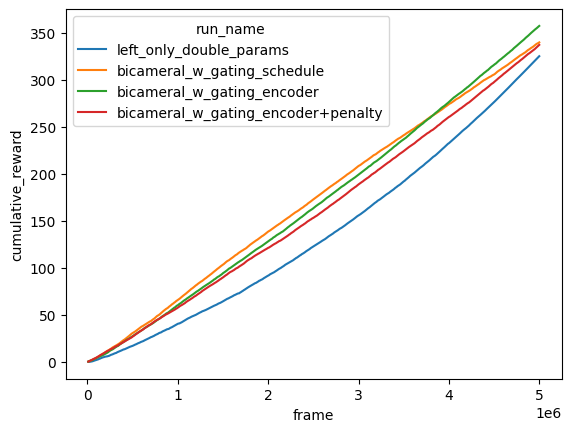

In [64]:
sns.lineplot(
    data = tmp_df,
    x='frame',
    y = 'cumulative_reward',
    hue='run_name'
)

<Axes: xlabel='frame', ylabel='diff'>

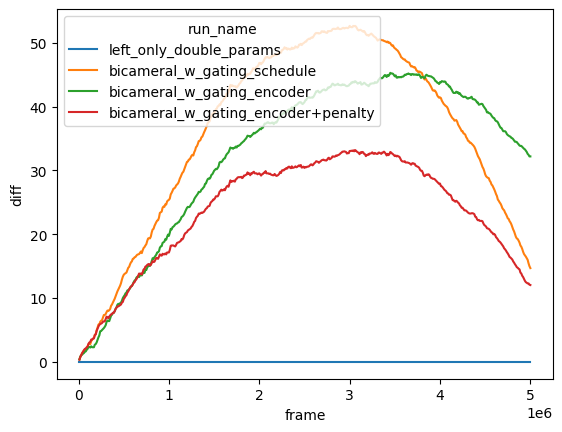

In [65]:
left_only_cumrew = (
    tmp_df
    .query('run_name=="left_only_double_params"')
)

df = (
    left_only_cumrew.drop('run_name', axis=1)
    .rename(columns = {'cumulative_reward': 'cumulative_reward_left'})
    .merge(
        tmp_df, on = 'frame'
    )
    .assign(
        diff = lambda x: x.cumulative_reward - x.cumulative_reward_left
    )
)

sns.lineplot(
    data=df,
    x='frame',
    y='diff',
    hue='run_name'
)

In [10]:
np.unique(df['training_task']).tolist()

['button-press-v2',
 'door-open-v2',
 'faucet-open-v2',
 'pick-place-v2',
 'push-v2',
 'reach-v2']

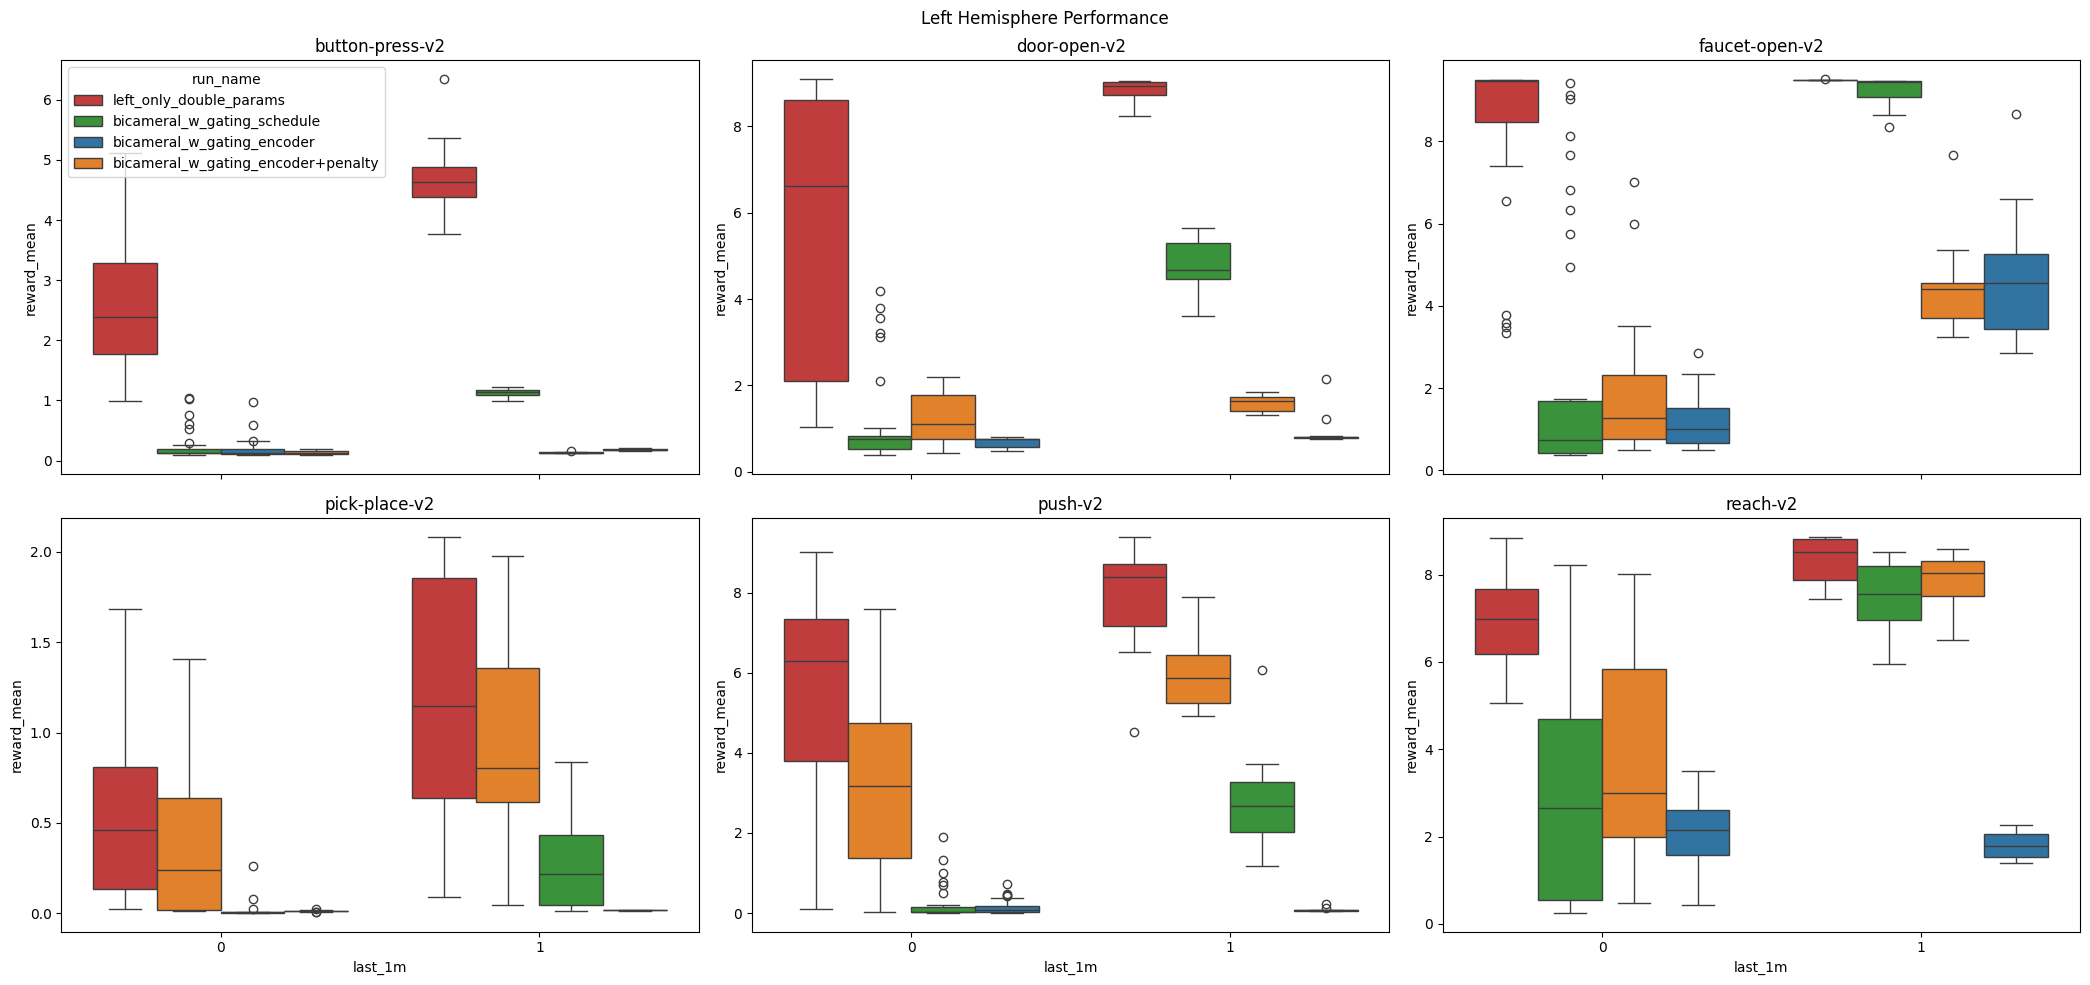

In [95]:
df = (
    pd.concat(
        [left_eval_data, test_data.query('run_name == "left_only_double_params"')]
    )
    .loc[:, ['training_task', 'frame','run_name', 'reward_mean']]
    .assign(last_1m = lambda x: 1*(x.frame >= 4000000))
)

fig, ax = plt.subplots(2, 3, figsize = (21, 10), sharex=True)
ax = ax.flatten()

training_tasks = np.unique(df['training_task']).tolist()

for i, task in enumerate(training_tasks):
    sns.boxplot(
        data = (
            df
            .query(f"training_task=='{task}'")
            .sort_values(['reward_mean'], ascending=False)
        ),
        x='last_1m',
        y='reward_mean',
        hue='run_name',
        ax=ax[i],
        palette=PALETTE
    )
    ax[i].set_title(f"{task}")
    if i > 0:
        ax[i].get_legend().remove()

plt.suptitle("Left Hemisphere Performance")
plt.tight_layout()
plt.show();

In [43]:
to_remove = ["random","right_only"]

time_to_vals = ['q_25', 'q_50', 'q_75', 'q_90']

df = (
    train_data
    # .query(f'~run_name.isin({to_remove})')
    .loc[:,['training_task','run_name', 'frame', 'reward_mean']]
)

quantiles=(
    df
    .loc[:,['training_task','run_name', 'reward_mean']]
    .groupby(['training_task','run_name'])
    .quantile([0.25, 0.5, 0.75, 0.9])
    .reset_index()
    .rename(columns={'level_2':'quantile'})
    .pivot_table(
        values=['reward_mean'],
        columns='quantile',
        index=['training_task', 'run_name']
    )
    .reset_index()
)
quantiles.columns = ['training_task','run_name'] + time_to_vals
time_to_data = (
    quantiles
    .merge(df, on=['run_name', 'training_task'])
    .assign(
        time_to_q_25=lambda x: x.frame * (x.reward_mean>=x.q_25),
        time_to_q_50=lambda x: x.frame * (x.reward_mean>=x.q_50),
        time_to_q_75=lambda x: x.frame * (x.reward_mean>=x.q_75),
        time_to_q_90=lambda x: x.frame * (x.reward_mean>=x.q_90)
    )
)

left_baseline_q = (
    quantiles
    .query('run_name=="left_only_double_params"')
    .loc[:,['training_task', 'run_name', *time_to_vals]]
)
q_to_left = pd.DataFrame()
for val in time_to_vals:
    tmp_left = (
        quantiles
        .loc[:,['training_task', 'run_name', val]]
        .merge(
            (
                left_baseline_q
                .loc[:, ['training_task', val]]
                .rename(columns={val:'baseline'})
            ), 
            on=['training_task']
        )
        .assign(**{f'{val}_ratio': lambda x: x[val] / x.baseline})
        .drop('baseline', axis=1)
        .set_index(['training_task', 'run_name'])

    )

    q_to_left = pd.concat([q_to_left, tmp_left], axis=1)

time_to_vals_dfs = pd.DataFrame()
for val in time_to_vals:
    tmp = (
        time_to_data
        .query(f'time_to_{val}> 0')
        .groupby(['training_task','run_name'])
        .agg({f'time_to_{val}':'min'})
        .reset_index()
    )
    baseline_vals = (
        tmp
        .query('run_name=="left_only_double_params"')
        .rename(columns={f'time_to_{val}':'baseline'})
        .drop('run_name', axis=1)
    )
    tmp = (
        tmp
        .merge(
            baseline_vals,
            on='training_task'
        )
        .assign(**{f'time_to_{val}_ratio': lambda x: x[f'time_to_{val}'] / x.baseline})
        .set_index(['training_task', 'run_name'])
    )

    time_to_vals_dfs = pd.concat([time_to_vals_dfs, tmp], axis = 1)


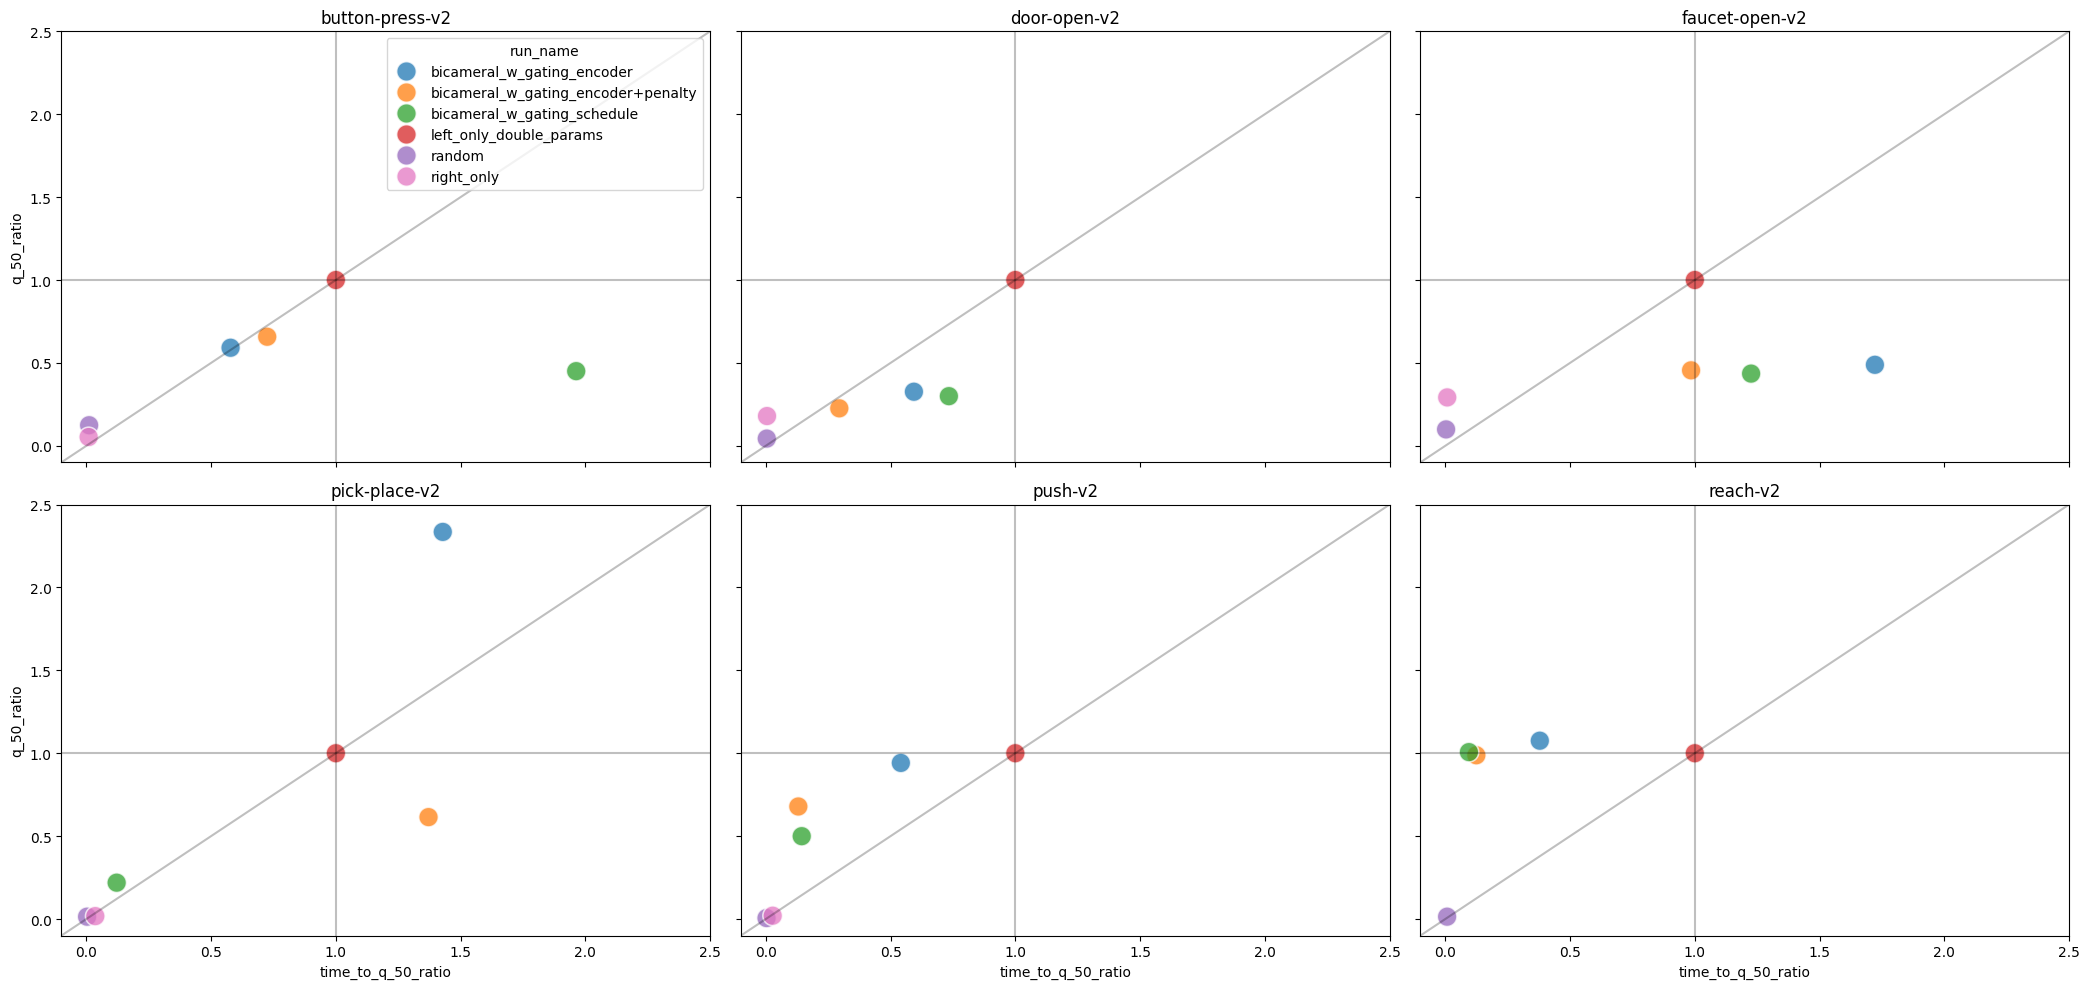

In [136]:
quantiles_and_times = pd.concat([time_to_vals_dfs, q_to_left], axis=1).reset_index()
fig, ax = plt.subplots(2, 3, figsize = (21, 10), sharex=True, sharey=True)
ax = ax.flatten()
to_plot = 'q_50'

for i, task in enumerate(training_tasks):
    sns.scatterplot(
        data = (
            quantiles_and_times
            .query(f"training_task=='{task}'")
        ),
        x=f'time_to_{to_plot}_ratio',
        y=f'{to_plot}_ratio',
        hue='run_name',
        ax=ax[i],
        palette=PALETTE,
        s = 200,
        alpha = 0.75
    )
    ax[i].set_title(f"{task}")
    ax[i].axhline(1, c='black', alpha=0.25)
    ax[i].axvline(1, c='black', alpha=0.25)
    ax[i].set_xlim(-.1, 2.5)
    ax[i].set_ylim(-.1, 2.5)

    ax[i].plot([-5., 5.], [-5.,5.], c='black', alpha=0.25)
    if i > 0:
        ax[i].get_legend().remove()


plt.tight_layout()
plt.show();


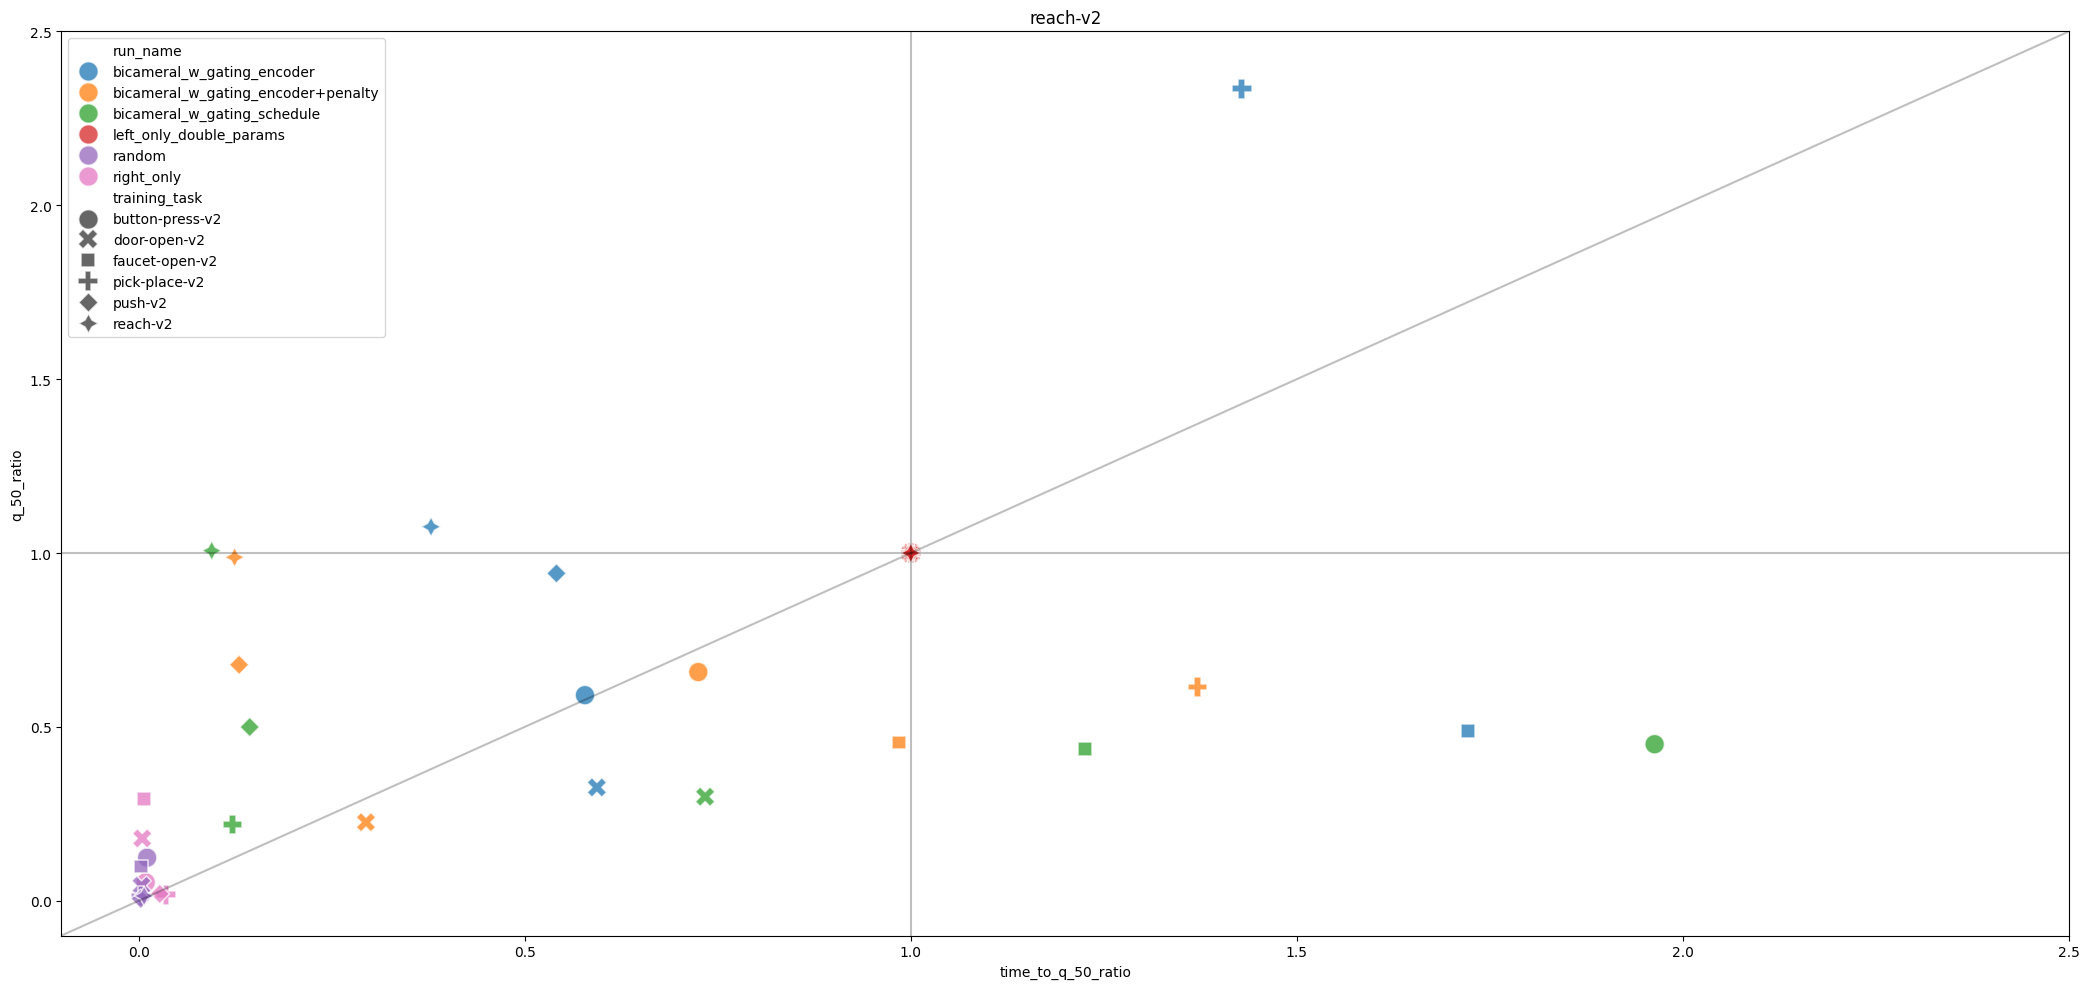

In [140]:
quantiles_and_times = pd.concat([time_to_vals_dfs, q_to_left], axis=1).reset_index()
fig, ax = plt.subplots(figsize = (21, 10), sharex=True, sharey=True)
# ax = ax.flatten()
to_plot = 'q_50'

sns.scatterplot(
    data = (
        quantiles_and_times
    ),
    x=f'time_to_{to_plot}_ratio',
    y=f'{to_plot}_ratio',
    hue='run_name',
    ax=ax,
    palette=PALETTE,
    s = 200,
    alpha = 0.75,
    style='training_task'
)
ax.set_title(f"{task}")
ax.axhline(1, c='black', alpha=0.25)
ax.axvline(1, c='black', alpha=0.25)
ax.set_xlim(-.1, 2.5)
ax.set_ylim(-.1, 2.5)

ax.plot([-5., 5.], [-5.,5.], c='black', alpha=0.25)



plt.tight_layout()
plt.show();


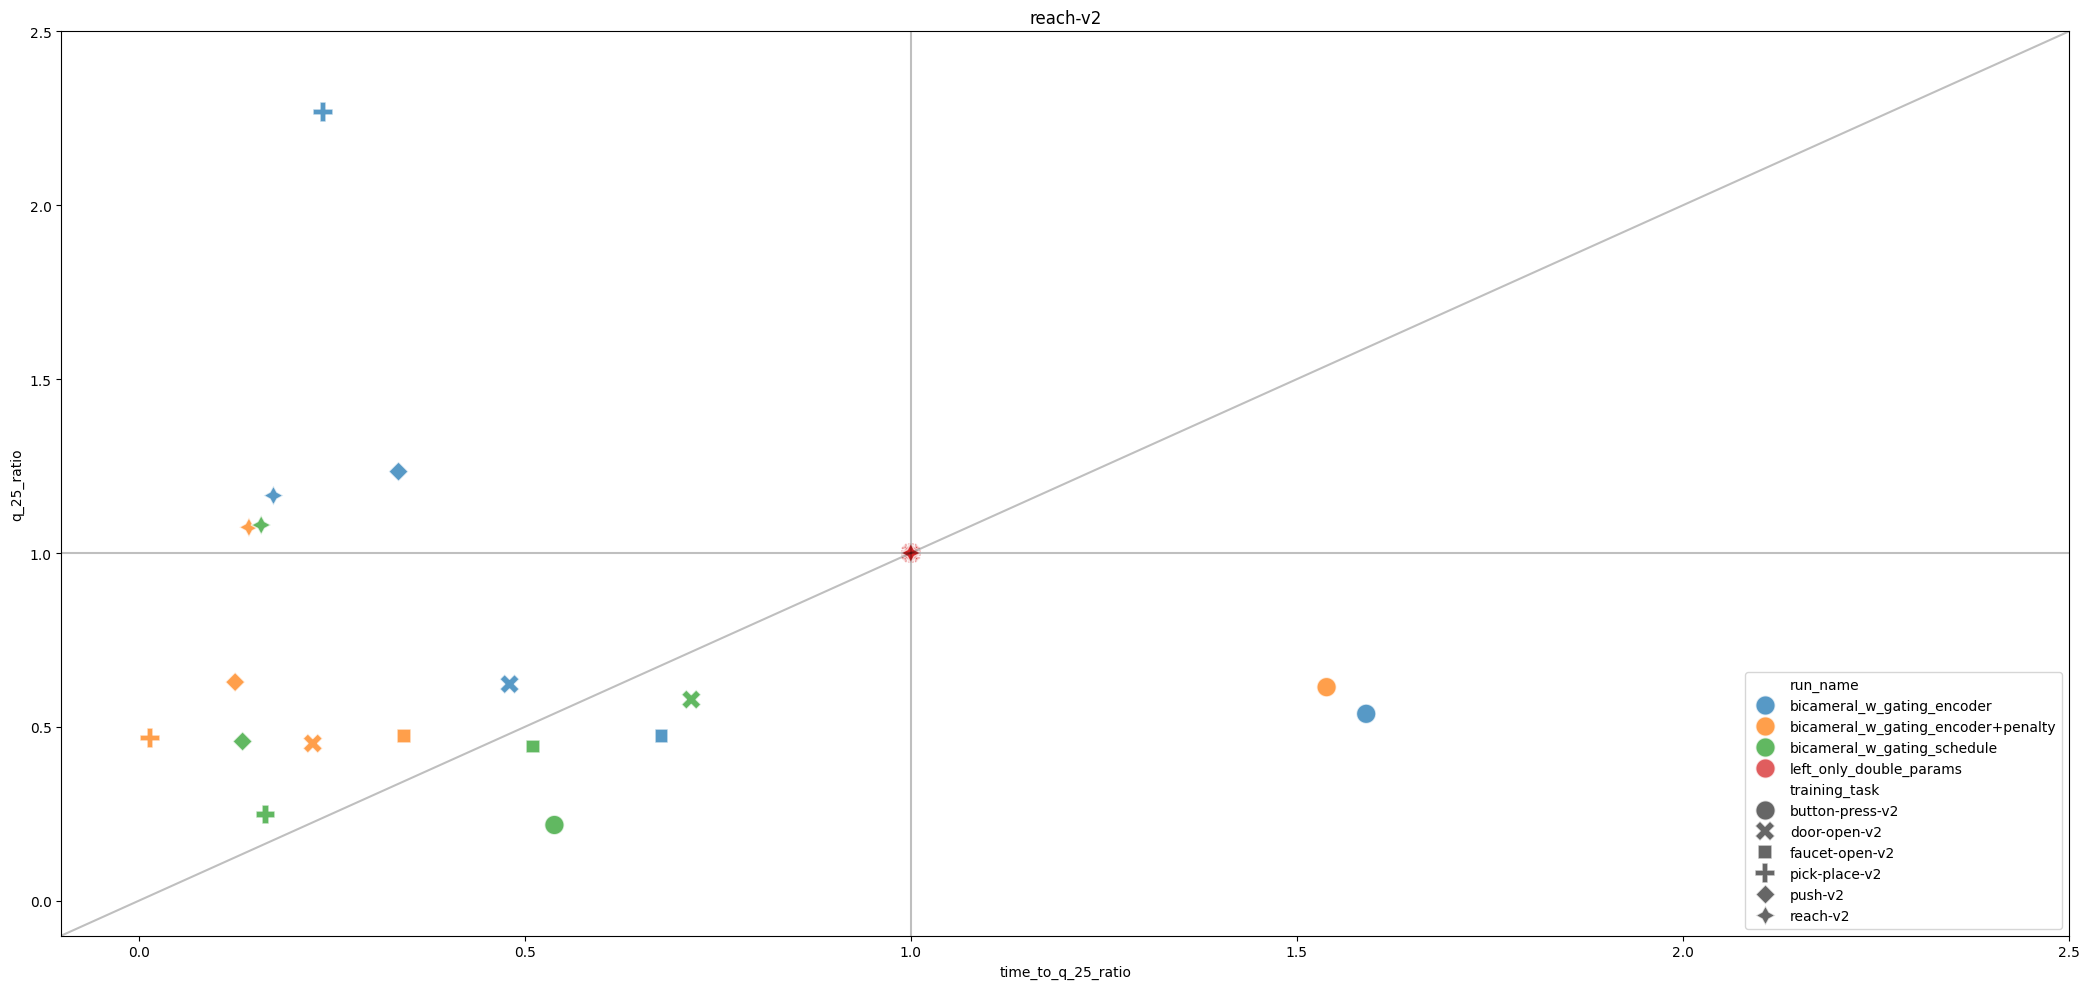

In [144]:
fig, ax = plt.subplots(figsize = (21, 10), sharex=True, sharey=True)
# ax = ax.flatten()
to_plot = 'q_25'

sns.scatterplot(
    data = (
        quantiles_and_times.query(f"~run_name.isin({to_remove})")
    ),
    x=f'time_to_{to_plot}_ratio',
    y=f'{to_plot}_ratio',
    hue='run_name',
    ax=ax,
    palette=PALETTE,
    s = 200,
    alpha = 0.75,
    style='training_task'
)
ax.set_title(f"{task}")
ax.axhline(1, c='black', alpha=0.25)
ax.axvline(1, c='black', alpha=0.25)
ax.set_xlim(-.1, 2.5)
ax.set_ylim(-.1, 2.5)

ax.plot([-5., 5.], [-5.,5.], c='black', alpha=0.25)



plt.tight_layout()
plt.show();

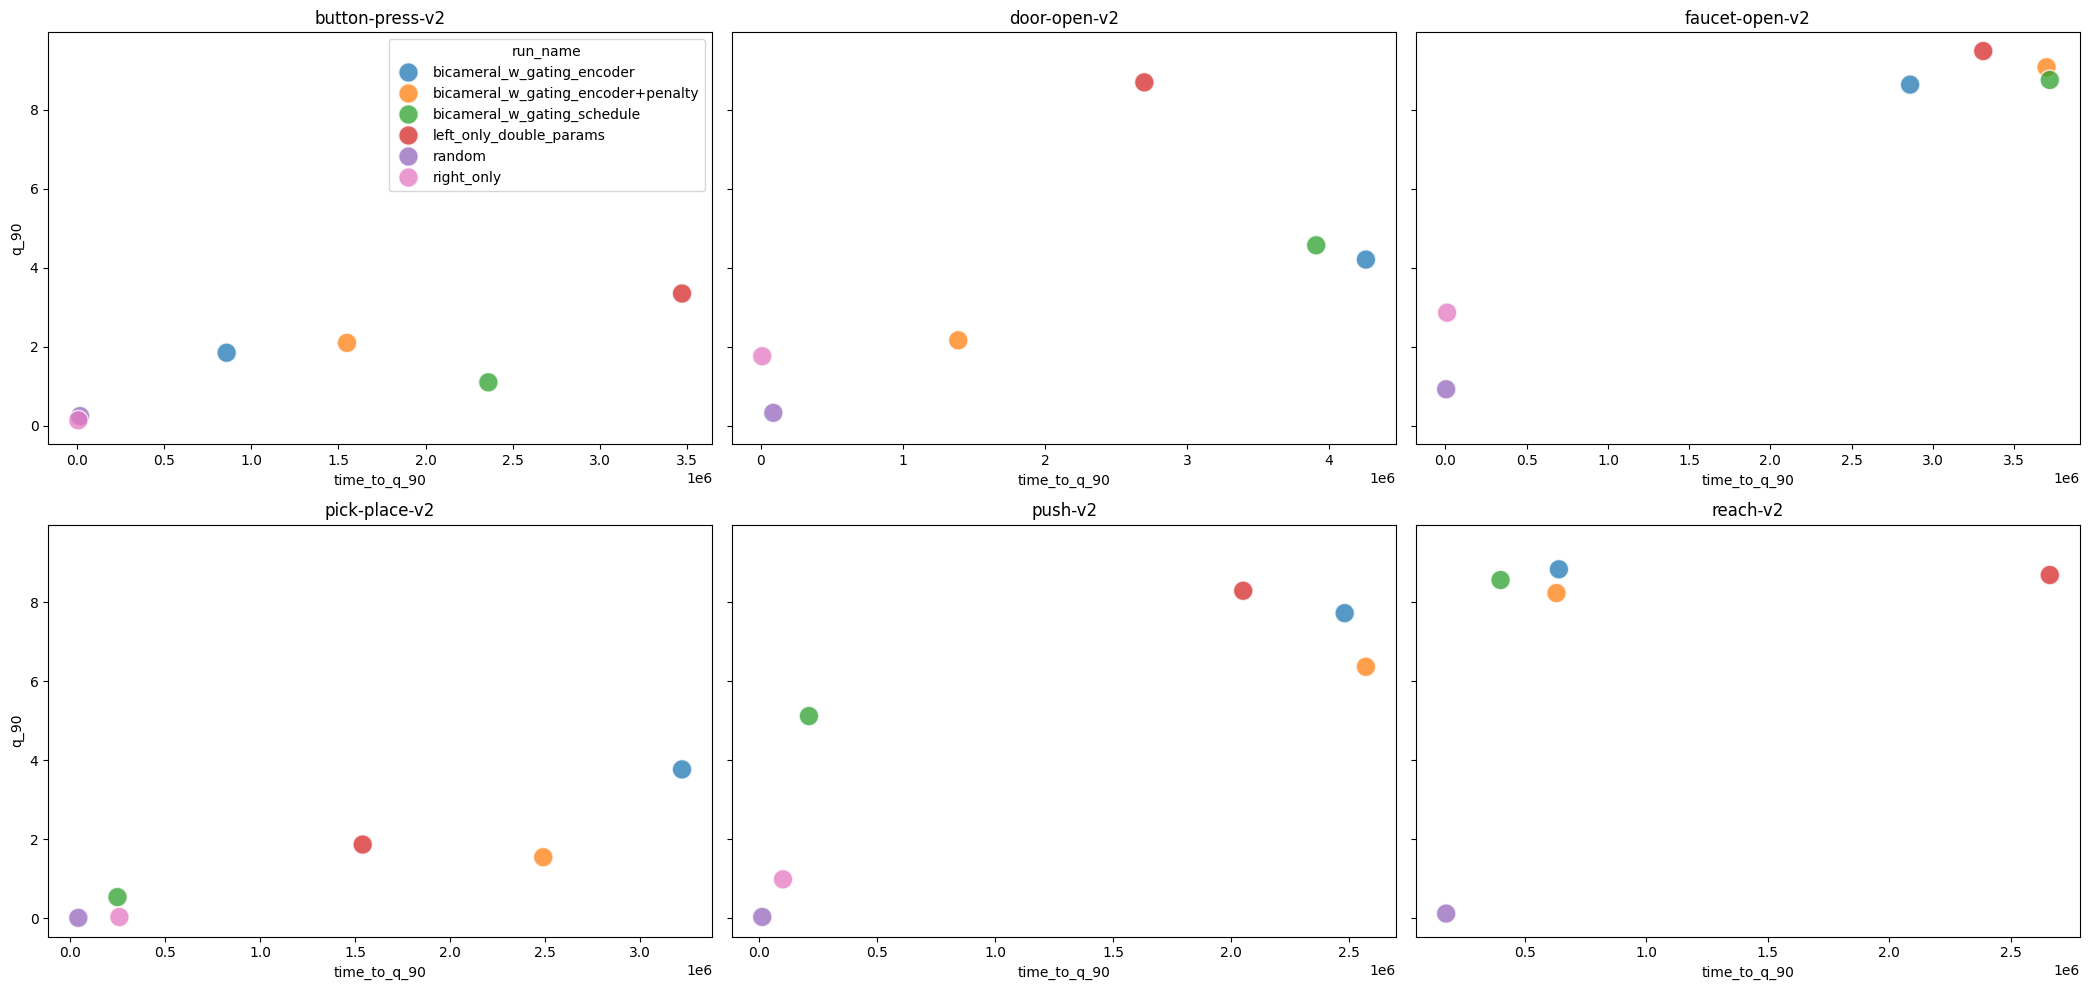

In [137]:
fig, ax = plt.subplots(2, 3, figsize = (21, 10), sharey=True)
ax = ax.flatten()
to_plot = 'q_90'

for i, task in enumerate(training_tasks):
    sns.scatterplot(
        data = (
            quantiles_and_times
            .query(f"training_task=='{task}'")
        ),
        x=f'time_to_{to_plot}',
        y=f'{to_plot}',
        hue='run_name',
        ax=ax[i],
        palette=PALETTE,
        s = 200,
        alpha = 0.75
    )
    ax[i].set_title(f"{task}")
    if i > 0:
        ax[i].get_legend().remove()


plt.tight_layout()
plt.show();

<Axes: xlabel='training_task', ylabel='reward_mean'>

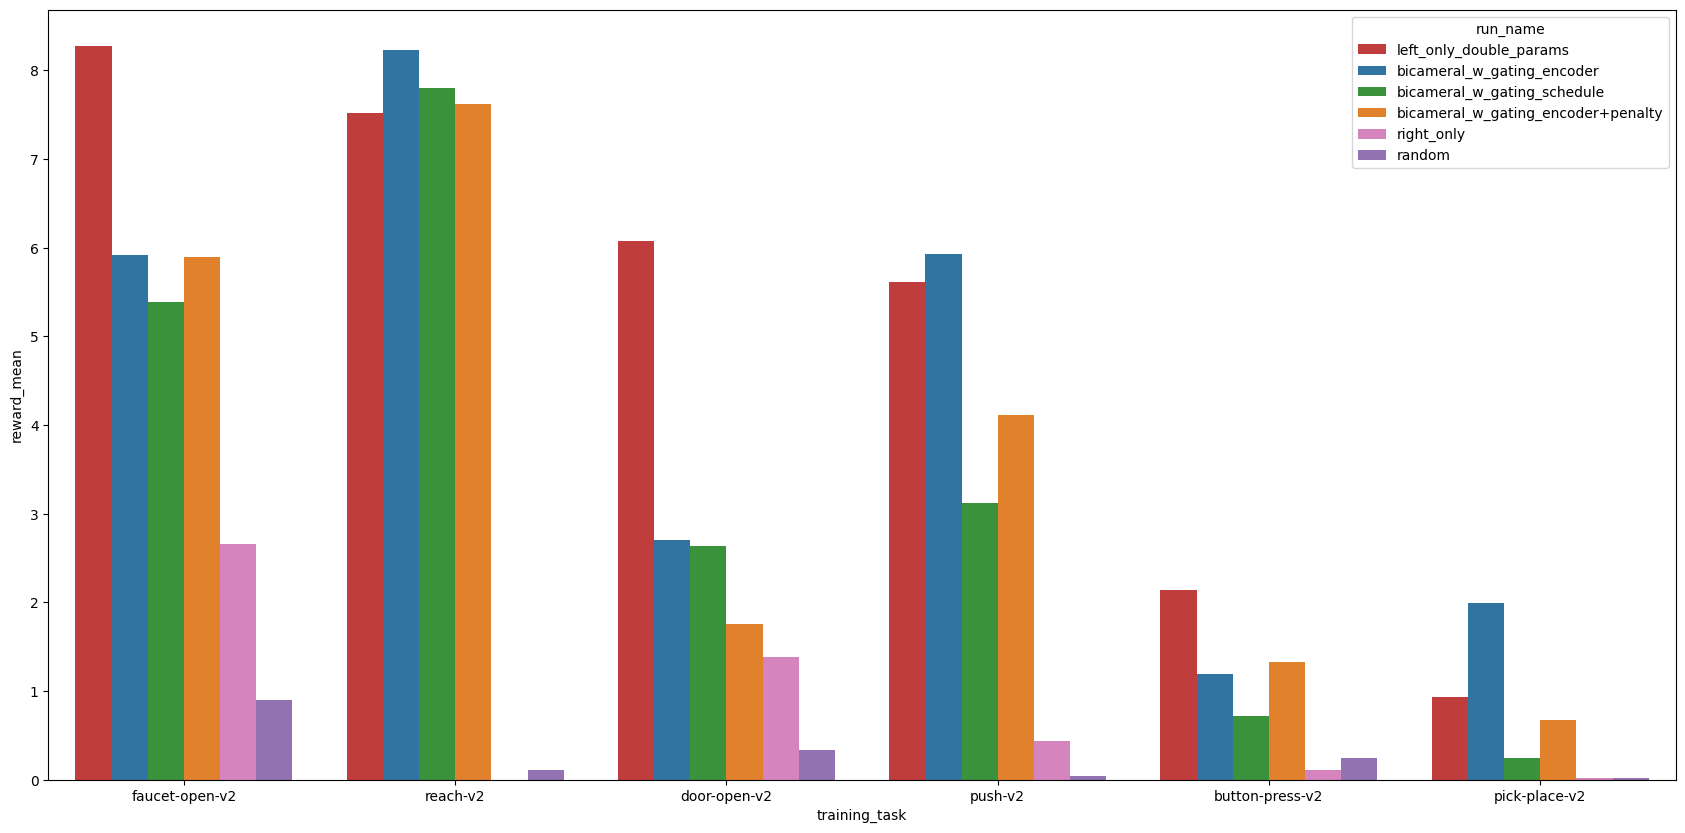

In [84]:
all_train = (
    train_data
    .loc[:,['training_task','run_name', 'reward_mean']]
    .groupby(['training_task','run_name'])
    .mean()
    .reset_index()

)
fig, ax = plt.subplots(figsize = (21, 10))
sns.barplot(
    data=all_train.sort_values('reward_mean', ascending=False),
    x='training_task',
    y='reward_mean',
    hue='run_name',
    palette=PALETTE
)

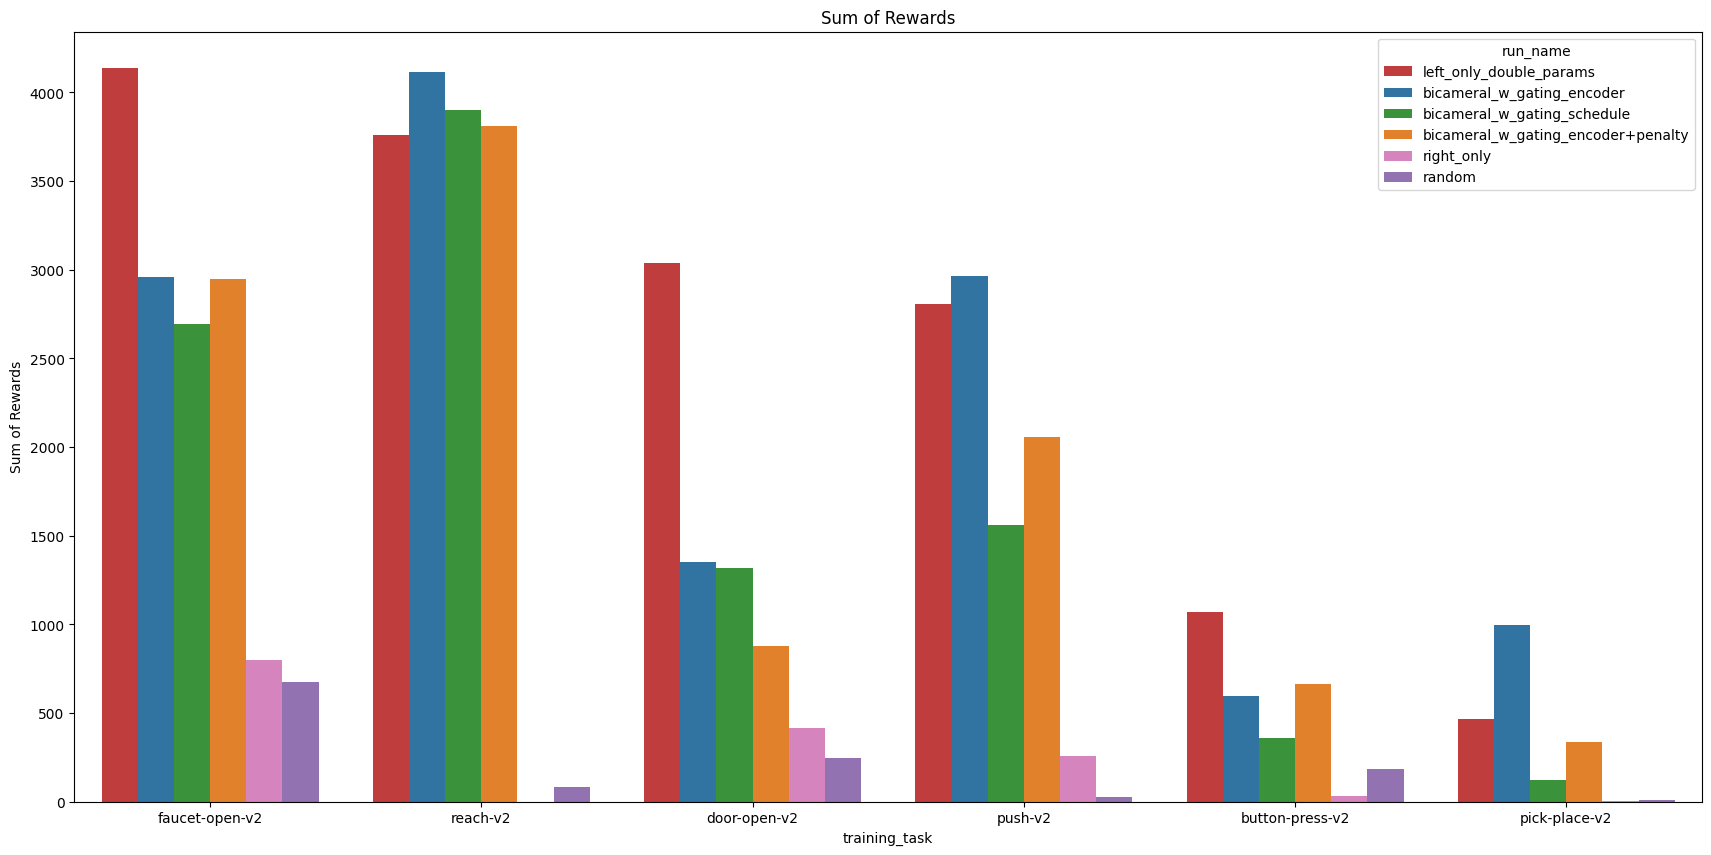

In [93]:
all_train = (
    train_data
    .loc[:,['training_task','run_name', 'reward_mean']]
    .groupby(['training_task','run_name'])
    .sum()
    .reset_index()

)
fig, ax = plt.subplots(figsize = (21, 10))
sns.barplot(
    data=all_train.sort_values('reward_mean', ascending=False),
    x='training_task',
    y='reward_mean',
    hue='run_name',
    palette=PALETTE
)
ax.set_title("Sum of Rewards");
ax.set_ylabel("Sum of Rewards");


Text(0.5, 1.0, 'Left Hemisphere Performance')

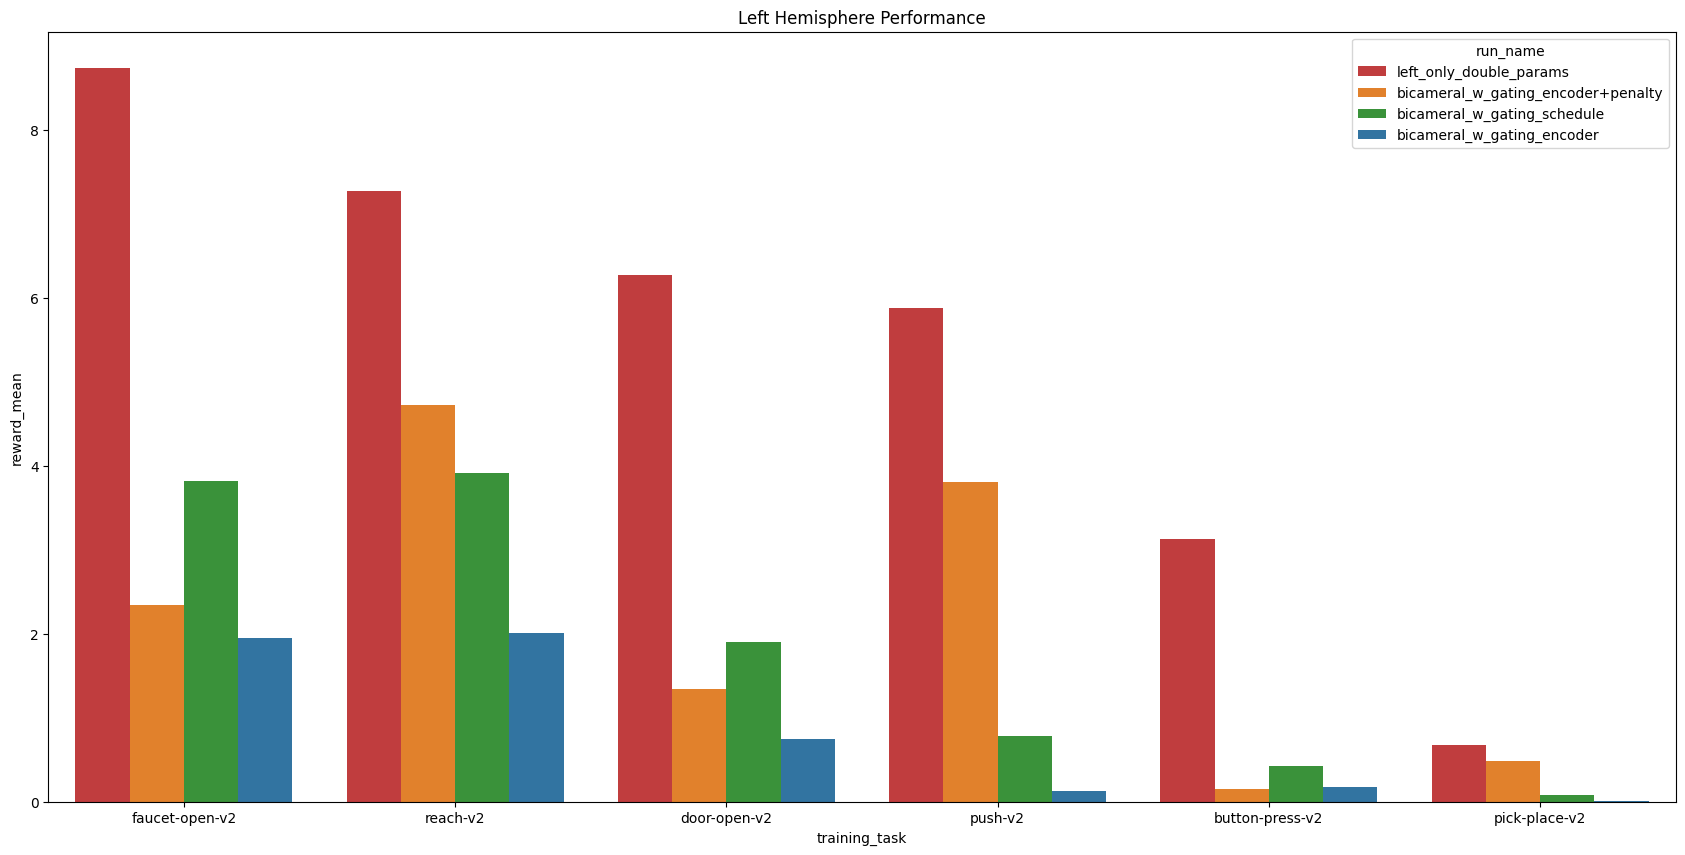

In [94]:
left_compare = (
    pd.concat(
        [
            test_data.query('run_name=="left_only_double_params"'), 
            left_eval_data]
    )
    .loc[:,['training_task','run_name', 'reward_mean']]
    .groupby(['training_task','run_name'])
    .mean()
    .reset_index()

)
fig, ax = plt.subplots(figsize = (21, 10))
sns.barplot(
    data=left_compare.sort_values('reward_mean', ascending=False),
    x='training_task',
    y='reward_mean',
    hue='run_name',
    palette=PALETTE
)
ax.set_title("Left Hemisphere Performance")

In [16]:
def plot_baseline_barchart(data, title, figsize= (20, 7)):

    plot_df = (
        data
        .melt(id_vars=['frame', 'result_group', 'run_name', 'training_task'])
        .set_index('frame')
        .query(f'variable.isin({REWARD_QUANTILES})')
        .groupby(['result_group', 'run_name', 'training_task', 'variable'])
        .mean()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(
        data = plot_df,
        x = 'run_name',
        y = 'value',
        ax = ax
    )
    ax.set_title(title)

    plt.show();

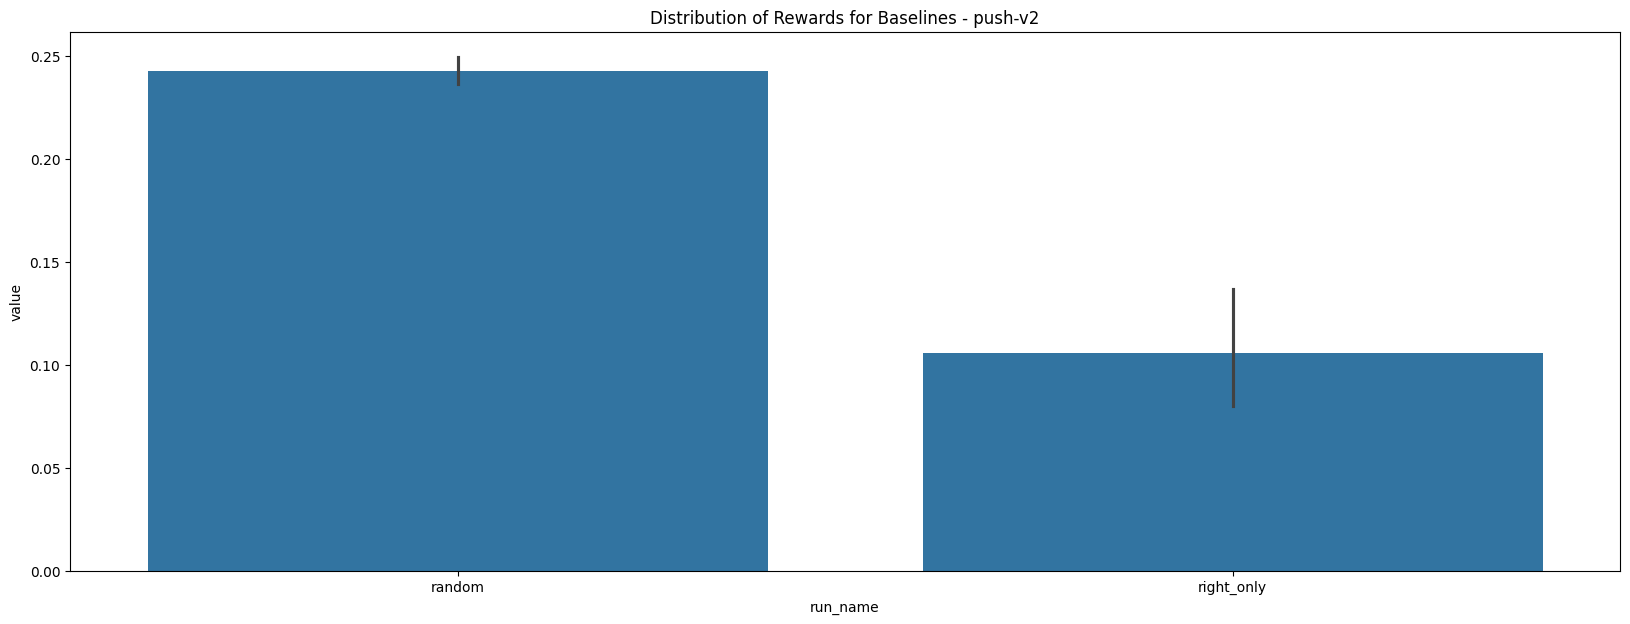

In [42]:
runs_to_do = ['right_only', 'random']
baseline_data = (
    train_data
    .query(f'run_name.isin({runs_to_do})')
)

plot_baseline_barchart(baseline_data, title="Distribution of Rewards for Baselines - push-v2")


In [29]:
np.unique(train_data.run_name)

array(['bicameral_w_gating_encoder', 'bicameral_w_gating_encoder+penalty',
       'bicameral_w_gating_schedule', 'left_only_double_params', 'random',
       'right_only'], dtype=object)

In [30]:


sns.lineplot(
    test_data,
    x
)

In [41]:
## plot training comparison - reward_mean, num_successes, reward_quantiles
## for train
train_results = (
    pd.concat(
        [all_results[k].data.query('result_group=="train_results"') for k in all_results.keys()]
    )
    .drop(['num_episodes', 'training_task', 'evaluation_task'], axis =1)
    .melt(id_vars = ['run_name', 'frame', 'result_group'])
)

## for test
## for test vs left
## note use right / random baselines for all

In [46]:
reward_quantiles = [f"rq_{i/10}" for i in range(1, 10)]

#### Compare whole bicameral to left_only network

In [117]:
avg_right_reward = right_only_results.data.reward_mean.mean()
avg_right_success = right_only_results.data.num_successes.mean()
combined_data = (
    pd.concat(
        [
            left_only_results.data, 
            (
                gate_lg_penalty_results
                .data
                .query('result_group.isin(["test_results", "train_results"])')
            )
        ]
    )
)


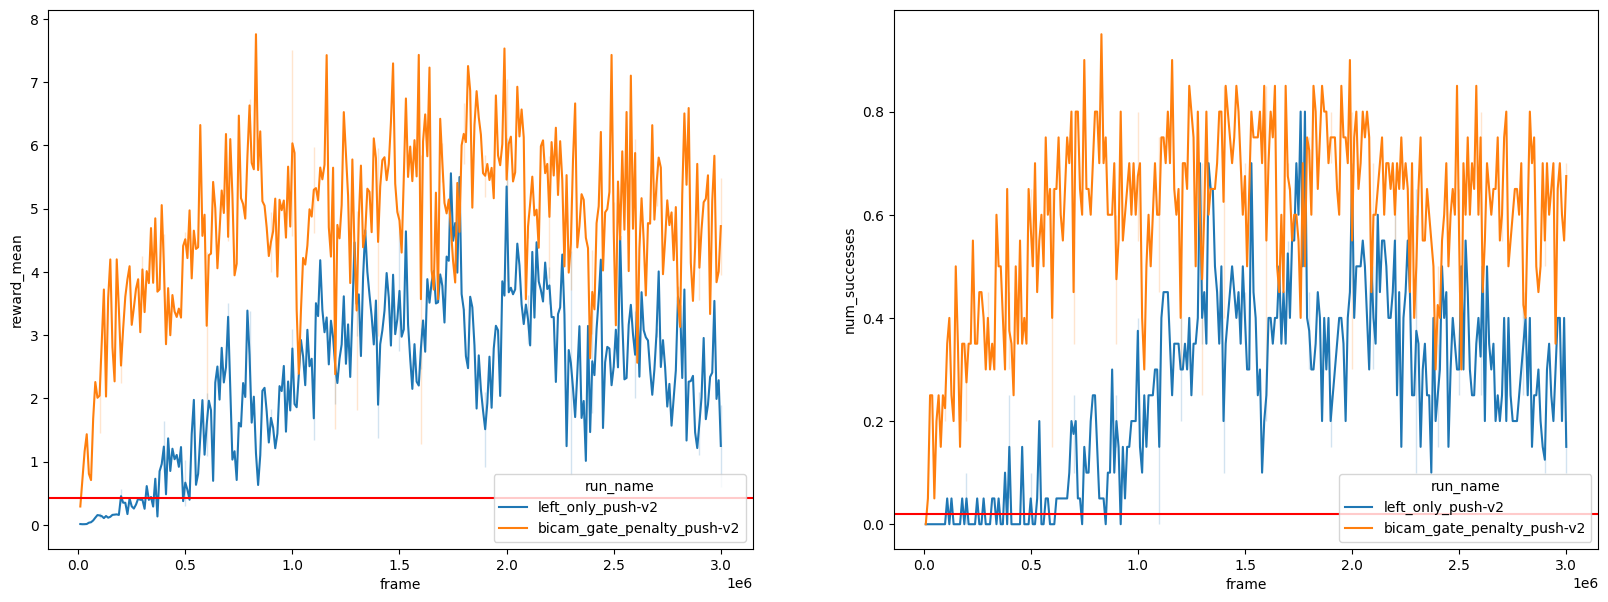

In [122]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

## mean reward
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'reward_mean',
    hue = 'run_name',
    ax = ax[0]
)

ax[0].axhline(avg_right_reward, c='r')

## successes
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'num_successes',
    hue = 'run_name',
    ax = ax[1]

)

ax[1].axhline(avg_right_success, c='r')

<Axes: xlabel='frame', ylabel='rq_0.9'>

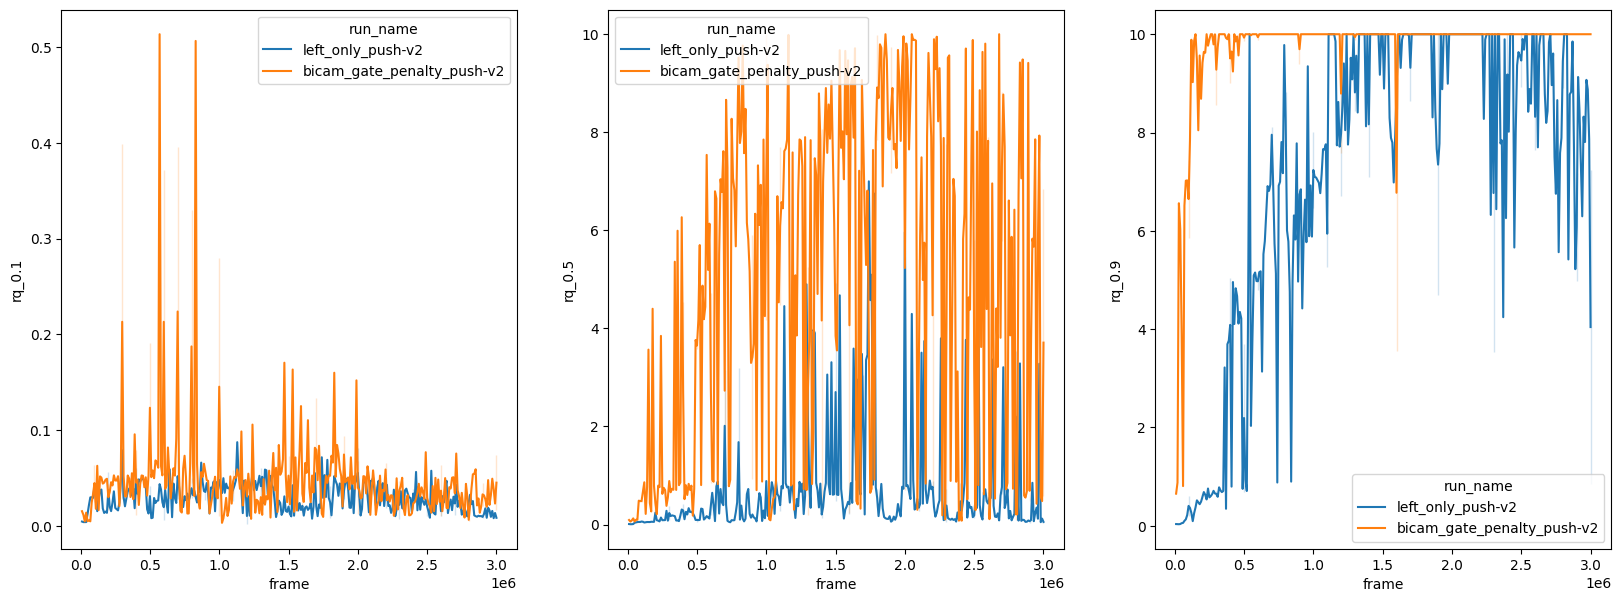

In [123]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

## lowest decile
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.1',
    hue = 'run_name',
    ax = ax[0]
)

## median
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.5',
    hue = 'run_name',
    ax = ax[1]
)

# highest decile
sns.lineplot(
    data = combined_data,
    x = 'frame',
    y = 'rq_0.9',
    hue = 'run_name',
    ax = ax[2]
)

#### Compare left bicameral to left_only network

In [112]:
combined_plot_df = (
    pd.concat([
        (
            left_only_results
            .data
            .query('result_group=="test_results"')
        ), 
        (
            gate_lg_penalty_results
            .data
            .query('result_group=="left_eval_results"')
        )
    ])
    .loc[:, 
    ['result_group', 'frame', 'run_name', 'num_successes', 'reward_mean'] +\
    [f"rq_{i/10}" for i in range(1, 10)] + [f"gq_{i/10}" for i in range(1, 10)]
    ]
)

    

<Axes: xlabel='frame', ylabel='num_successes'>

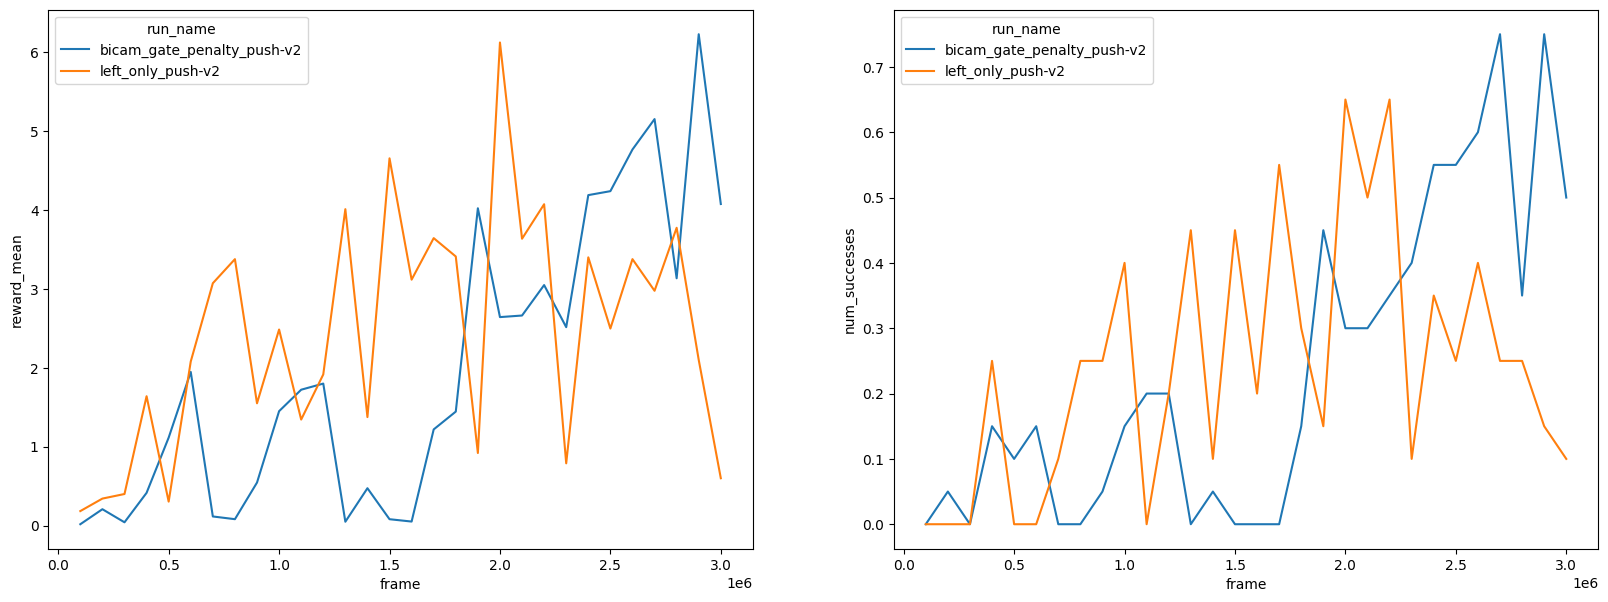

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

## mean reward
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'reward_mean',
    hue = 'run_name',
    ax = ax[0]
)

## successes
sns.lineplot(
    data = combined_plot_df,
    x = 'frame',
    y = 'num_successes',
    hue = 'run_name',
    ax = ax[1]

)

<Axes: xlabel='frame', ylabel='value'>

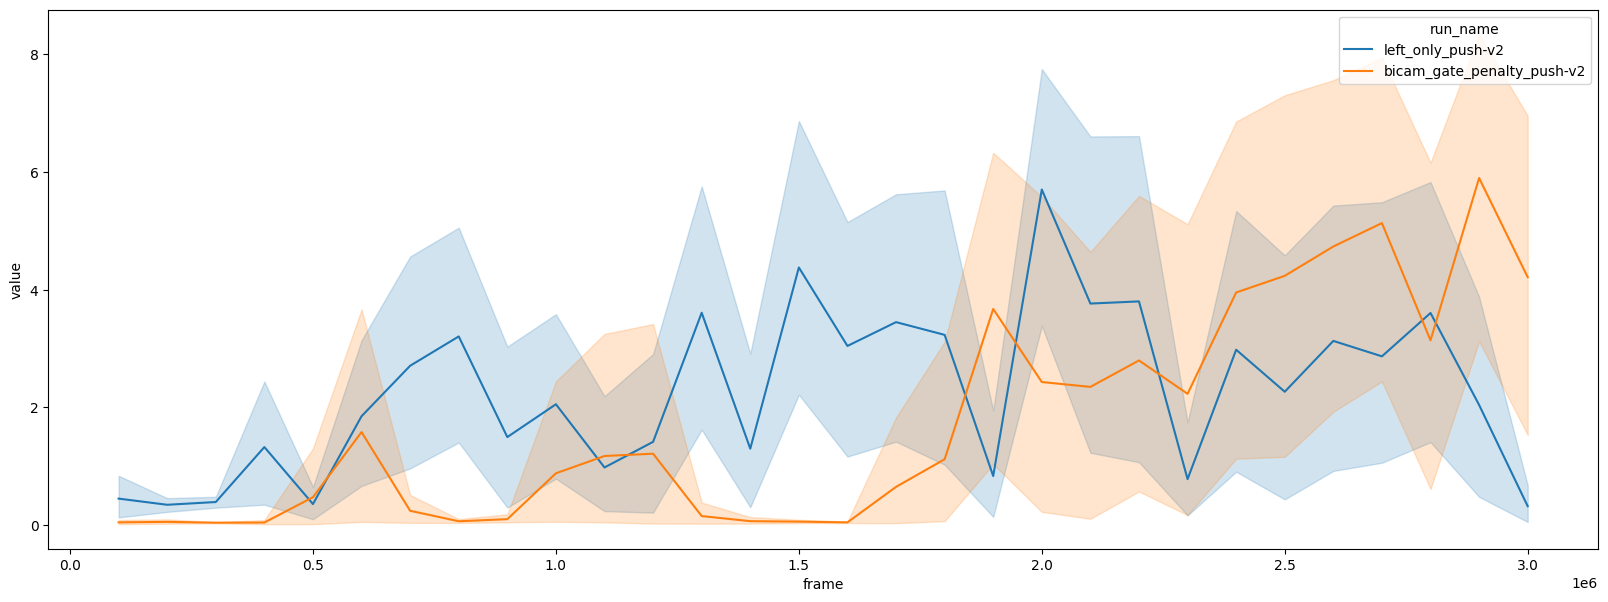

In [136]:
reward_qtiles = (
    combined_plot_df
    .melt(
        id_vars = ['result_group', 'run_name', 'frame'],
        value_vars = [f'rq_{i/10}' for i in range(1, 10)]
    )
    .set_index(['result_group', 'run_name', 'frame', 'variable'])
    .ewm(alpha = 0.9).mean()
)

fig, ax = plt.subplots(figsize = (20, 7))
sns.lineplot(
    data = reward_qtiles,
    x = 'frame',
    y = 'value',
    hue = 'run_name',
    ax = ax
)